In [4]:
import backtrader as bt
import pandas as pd

In [5]:
import setup
setup.init_django()
from market import services as market_services

ticker = "NVDA"  
days = 720 

# Fetch data
queryset = market_services.get_5min_stock_quotes_queryset(ticker, days=days)
df = pd.DataFrame.from_records(list(queryset.values()))
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

df = df.rename(columns={
    'open_price': 'Open',
    'high_price': 'High',
    'low_price': 'Low',
    'close_price': 'Close',
    'volume': 'Volume'
})

df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].astype(float)
df.index = df.index.tz_localize(None)  
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

df = df.resample('1D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()

In [6]:
class MACrossover(bt.Strategy):
    params = (('sma_fast', 20), ('sma_slow', 50))

    def __init__(self):
        self.sma_fast = bt.ind.SMA(period=self.params.sma_fast)
        self.sma_slow = bt.ind.SMA(period=self.params.sma_slow)
        self.crossover = bt.ind.CrossOver(self.sma_fast, self.sma_slow)

    def next(self):
        if not self.position:
            if self.crossover > 0:  
                self.order_target_percent(target=1.0)
        elif self.crossover < 0:  
            self.order_target_percent(target=0.0)

In [7]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['backend'] = 'module://matplotlib_inline.backend_inline'

Starting Portfolio Value: 100000.00
Final Portfolio Value: 116404.46
Return: OrderedDict([('rtot', 0.15190066644455122), ('ravg', 0.0006200027201818417), ('rnorm', 0.16910755644988057), ('rnorm100', 16.910755644988058)])
Sharpe Ratio: OrderedDict([('sharperatio', 0.8780819377403226)])


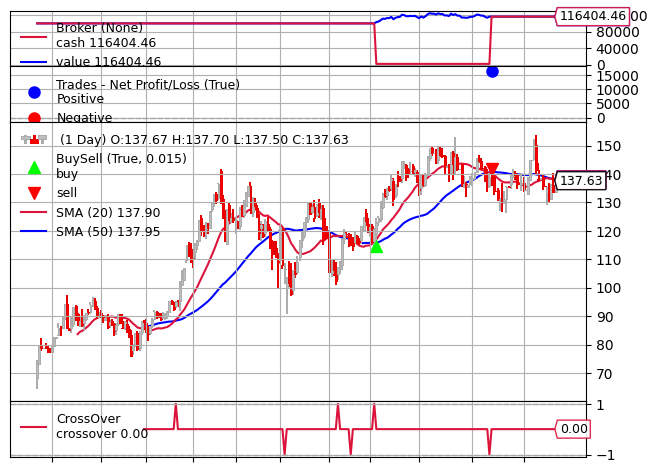

[[<Figure size 640x480 with 4 Axes>]]

In [8]:
cerebro = bt.Cerebro()
data = bt.feeds.PandasData(dataname=df)  
cerebro.adddata(data)
cerebro.addstrategy(MACrossover)
cerebro.broker.setcash(100000)
cerebro.broker.setcommission(commission=0.001)  

cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')

print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())
results = cerebro.run()
print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())

# Print analyzers
strat = results[0]
print("Return:", strat.analyzers.returns.get_analysis())
print("Sharpe Ratio:", strat.analyzers.sharpe.get_analysis())

cerebro.plot(style='candlestick', iplot=False, volume=False)